# Functional Annotation Analysis

This notebook loads and visualizes:

1. **BLASTp hits** against _Prunus armeniaca_ and their associated GO terms  
2. **InterProScan** domain/signature annotations  

We will generate summary tables and simple plots to include in your TFM write‐up.

In [25]:
# Cell 1: Imports and settings
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os

# Make plots inline and set a clean style
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)


## 1. Load BLAST+GO Results

The file `blast_with_GO.tsv` contains BLAST hits (one per line) plus a collapsed list of GO IDs per hit.

In [16]:
# Cell 2: Load blast_with_GO.tsv
blast_go_path = "/data/training2/analisis_TFM_Bulida_Precoz/10_functional_annotation/blast_with_GO.tsv"
df_blast = pd.read_csv(blast_go_path, sep="\t")

# inspect
df_blast.head()


,qseqid,accession,pident,length,evalue,bitscore,title,GO_IDs
0,A0A6J5TEZ0,Gene_9712.1,100.000,70,6.750000e-48,150.0,tr|A0A6J5TEZ0|A0A6J5TEZ0_PRUAR Peroxiredoxin O...,GO:0005739; GO:0005829; GO:0045454; GO:0140824
1,A0A6J5U7H0,Gene_20739.1,94.231,52,2.580000e-19,79.7,tr|A0A6J5U7H0|A0A6J5U7H0_PRUAR DNA-directed RN...,GO:0000428; GO:0003677; GO:0005730; GO:0006351
2,A0A6J5UKQ5,Gene_26305.1,100.000,70,7.770000e-47,155.0,tr|A0A6J5UKQ5|A0A6J5UKQ5_PRUAR Methyltransfera...,NaN
3,A0A6J5VFW8,Gene_9712.1,34.783,69,1.660000e-09,52.0,tr|A0A6J5VFW8|A0A6J5VFW8_PRUAR thioredoxin-dep...,GO:0006979; GO:0008379; GO:0033554; GO:0042744...
4,A0A6J5VP19,Gene_42548.1,100.000,70,6.760000e-41,140.0,tr|A0A6J5VP19|A0A6J5VP19_PRUAR RRM domain-cont...,GO:0003723; GO:0005634; GO:0006397; GO:0008380


### 1.1 How many hits and how many unique genes?


In [17]:
print("Total BLAST rows:", len(df_blast))
print("Unique query proteins:", df_blast['qseqid'].nunique())
print("Unique subject accessions:", df_blast['accession'].nunique())


Total BLAST rows: 9
Unique query proteins: 7
Unique subject accessions: 6


## 2. GO Term Analysis

Split the semicolon‐separated GO_IDs into one row per (hit, GO).


In [27]:
# Cell 3: Explode GO terms, extract gene descriptions & pivot GO terms wide

# Disable row truncation
pd.set_option('display.max_rows', None)

# ----- Part A: Explode GO terms -----
df_go = df_blast[['qseqid','accession','GO_IDs']].copy()
df_go = df_go[df_go['GO_IDs'].notna() & (df_go['GO_IDs'] != "")]
df_go['GO_ID'] = df_go['GO_IDs'].str.split(r'\s*;\s*')
df_go = df_go.explode('GO_ID').drop(columns=['GO_IDs'])
df_go['GO_ID'] = df_go['GO_ID'].str.strip()

# ----- Part B: Pivot GO terms into wide format -----
go_lists = df_go.groupby('accession')['GO_ID'].apply(list)
go_wide = go_lists.apply(
    lambda lst: pd.Series(lst, index=[f'GO_{i+1}' for i in range(len(lst))])
).reset_index()

# ----- Part C: Extract clean descriptions -----
desc_df = (
    df_blast[['accession','title']]
    .drop_duplicates()
    .assign(Description=lambda d: d['title'].str.extract(r'_PRUAR\s+(.+?)\s+OS='))
    [['accession','Description']]
    .reset_index(drop=True)
)

# Display all three tables
display(go_wide)    # GO terms pivoted wide
display(desc_df)    # Gene description

# Ensure output directory exists
out_dir = "/data/training2/analisis_TFM_Bulida_Precoz/10_functional_annotation/blast_annotation"
os.makedirs(out_dir, exist_ok=True)

# Save exploded GO terms
df_go.to_csv(
    os.path.join(out_dir, "exploded_go_terms.tsv"),
    sep="\t", index=False
)

# Save GO terms (wide format)
go_wide.to_csv(
    os.path.join(out_dir, "go_terms_wide.tsv"),
    sep="\t", index=False
)

# Save accession → description mapping
desc_df.to_csv(
    os.path.join(out_dir, "accession_descriptions.tsv"),
    sep="\t", index=False
)

print("TSV files saved to:\n", out_dir)

,accession,GO_1,GO_2,GO_3,GO_4,GO_5,GO_6,GO_7,GO_8,GO_9
0,Gene_20739.1,GO:0000428,GO:0003677,GO:0005730,GO:0006351,GO:0000428,GO:0003677,GO:0005730,GO:0006351,NaN
1,Gene_42548.1,GO:0003723,GO:0005634,GO:0006397,GO:0008380,NaN,NaN,NaN,NaN,NaN
2,Gene_42548.2,GO:0003723,GO:0005634,GO:0006397,GO:0008380,NaN,NaN,NaN,NaN,NaN
3,Gene_42548.3,GO:0003723,GO:0005634,GO:0006397,GO:0008380,NaN,NaN,NaN,NaN,NaN
4,Gene_9712.1,GO:0005739,GO:0005829,GO:0045454,GO:0140824,GO:0006979,GO:0008379,GO:0033554,GO:0042744,GO:0045454


,accession,Description
0,Gene_9712.1,Peroxiredoxin
1,Gene_20739.1,DNA-directed RNA polymerase I subunit rpa49
2,Gene_26305.1,Methyltransferase domain-containing protein
3,Gene_9712.1,thioredoxin-dependent peroxiredoxin
4,Gene_42548.1,RRM domain-containing protein
5,Gene_42548.2,RRM domain-containing protein
6,Gene_42548.3,RRM domain-containing protein
7,Gene_20739.1,DNA-directed RNA polymerase I subunit rpa49
8,Gene_26305.1,Methyltransferase domain-containing protein


TSV files saved to:
 /data/training2/analisis_TFM_Bulida_Precoz/10_functional_annotation/blast_annotation


### 2.1 Top 10 most frequent GO terms


In [29]:
# Cell 4: Count GO term frequency
go_counts = df_go['GO_ID'].value_counts().head(10)
go_counts

# Export summary tables
summary_dir = "/data/training2/analisis_TFM_Bulida_Precoz/10_functional_annotation/blast_annotation"
# write CSVs
go_counts.to_csv(os.path.join(summary_dir, "top_go_terms.tsv"), header=["count"])

print("Summaries written to", summary_dir)


Summaries written to /data/training2/analisis_TFM_Bulida_Precoz/10_functional_annotation/blast_annotation


## 3. InterProScan Domain/Signature Summary

Load your InterProScan TSV results and summarize which analyses returned most signatures.


In [6]:
# Cell 6: Load InterProScan results
ips_path = "/data/training2/analisis_TFM_Bulida_Precoz/10_functional_annotation/interproscan_results.tsv"
ips_cols = [
    "ProteinAccession","SequenceMD5","Length","Analysis",
    "SignatureAccession","SignatureDescription",
    "Start","End","Score","Status","Date",
    "InterProAcc","InterProDesc","GO","Pathways"
]
df_ips = pd.read_csv(ips_path, sep="\t", names=ips_cols, comment="#", low_memory=False)
df_ips.head()


,ProteinAccession,SequenceMD5,Length,Analysis,SignatureAccession,SignatureDescription,Start,End,Score,Status,Date,InterProAcc,InterProDesc,GO,Pathways
0,Gene_42548.2,9c1bbefa5278f07739aed317471be2a2,70,MobiDBLite,mobidb-lite,consensus disorder prediction,1,70,-,T,12-07-2025,-,-,NaN,NaN
1,Gene_42548.2,9c1bbefa5278f07739aed317471be2a2,70,MobiDBLite,mobidb-lite,consensus disorder prediction,38,70,-,T,12-07-2025,-,-,NaN,NaN
2,Gene_42548.1,9c1bbefa5278f07739aed317471be2a2,70,MobiDBLite,mobidb-lite,consensus disorder prediction,1,70,-,T,12-07-2025,-,-,NaN,NaN
3,Gene_42548.1,9c1bbefa5278f07739aed317471be2a2,70,MobiDBLite,mobidb-lite,consensus disorder prediction,38,70,-,T,12-07-2025,-,-,NaN,NaN
4,Gene_42548.3,9c1bbefa5278f07739aed317471be2a2,70,MobiDBLite,mobidb-lite,consensus disorder prediction,1,70,-,T,12-07-2025,-,-,NaN,NaN


### 4. Functional GO Term Summary for Apricot (‘Bulida Precoz’) Variant Genes**

- Load the exploded GO terms, gene descriptions and wide GO-term tables
- Compute GO–term frequencies
- Merge gene descriptions with GO-term lists
- Visualize the top GO terms
- Save all summary tables and figures for inclusion in the TFM report


In [30]:
# Cell 7: Imports & settings

import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Display full DataFrames
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Define paths
BASE       = "/data/training2/analisis_TFM_Bulida_Precoz/10_functional_annotation"
ANN_DIR    = os.path.join(BASE, "blast_annotation")
EXPLODE_F  = os.path.join(ANN_DIR, "exploded_go_terms.tsv")
DESC_F     = os.path.join(ANN_DIR, "accession_descriptions.tsv")
WIDE_F     = os.path.join(ANN_DIR, "go_terms_wide.tsv")

# Ensure annotation directory exists
os.makedirs(ANN_DIR, exist_ok=True)


## Load the data tables


In [31]:
df_go   = pd.read_csv(EXPLODE_F, sep="\t")
df_desc = pd.read_csv(DESC_F,    sep="\t")
df_wide = pd.read_csv(WIDE_F,    sep="\t")

print("Exploded GO terms:")
display(df_go)
print("Accession → Description:")
display(df_desc)
print("GO terms (wide):")
display(df_wide)


Exploded GO terms:


,qseqid,accession,GO_ID
0,A0A6J5TEZ0,Gene_9712.1,GO:0005739
1,A0A6J5TEZ0,Gene_9712.1,GO:0005829
2,A0A6J5TEZ0,Gene_9712.1,GO:0045454
3,A0A6J5TEZ0,Gene_9712.1,GO:0140824
4,A0A6J5U7H0,Gene_20739.1,GO:0000428
5,A0A6J5U7H0,Gene_20739.1,GO:0003677
6,A0A6J5U7H0,Gene_20739.1,GO:0005730
7,A0A6J5U7H0,Gene_20739.1,GO:0006351
8,A0A6J5VFW8,Gene_9712.1,GO:0006979
9,A0A6J5VFW8,Gene_9712.1,GO:0008379


Accession → Description:


,accession,Description
0,Gene_9712.1,Peroxiredoxin
1,Gene_20739.1,DNA-directed RNA polymerase I subunit rpa49
2,Gene_26305.1,Methyltransferase domain-containing protein
3,Gene_9712.1,thioredoxin-dependent peroxiredoxin
4,Gene_42548.1,RRM domain-containing protein
5,Gene_42548.2,RRM domain-containing protein
6,Gene_42548.3,RRM domain-containing protein
7,Gene_20739.1,DNA-directed RNA polymerase I subunit rpa49
8,Gene_26305.1,Methyltransferase domain-containing protein


GO terms (wide):


,accession,GO_1,GO_2,GO_3,GO_4,GO_5,GO_6,GO_7,GO_8,GO_9
0,Gene_20739.1,GO:0000428,GO:0003677,GO:0005730,GO:0006351,GO:0000428,GO:0003677,GO:0005730,GO:0006351,NaN
1,Gene_42548.1,GO:0003723,GO:0005634,GO:0006397,GO:0008380,NaN,NaN,NaN,NaN,NaN
2,Gene_42548.2,GO:0003723,GO:0005634,GO:0006397,GO:0008380,NaN,NaN,NaN,NaN,NaN
3,Gene_42548.3,GO:0003723,GO:0005634,GO:0006397,GO:0008380,NaN,NaN,NaN,NaN,NaN
4,Gene_9712.1,GO:0005739,GO:0005829,GO:0045454,GO:0140824,GO:0006979,GO:0008379,GO:0033554,GO:0042744,GO:0045454


## Compute GO-term frequencies & merge with descriptions

In [32]:
# 1) GO-term counts
go_counts = (
    df_go['GO_ID']
    .value_counts()
    .reset_index()
    .rename(columns={'index':'GO_ID','GO_ID':'Count'})
)
display(go_counts)

# 2) Merge descriptions into the wide GO table
genes_summary = (
    df_wide
    .merge(df_desc, on='accession', how='left')
)
display(genes_summary)


,Count,count
0,GO:0003723,3
1,GO:0005634,3
2,GO:0006397,3
3,GO:0008380,3
4,GO:0045454,2
5,GO:0005730,2
6,GO:0003677,2
7,GO:0000428,2
8,GO:0006351,2
9,GO:0005829,1


,accession,GO_1,GO_2,GO_3,GO_4,GO_5,GO_6,GO_7,GO_8,GO_9,Description
0,Gene_20739.1,GO:0000428,GO:0003677,GO:0005730,GO:0006351,GO:0000428,GO:0003677,GO:0005730,GO:0006351,NaN,DNA-directed RNA polymerase I subunit rpa49
1,Gene_20739.1,GO:0000428,GO:0003677,GO:0005730,GO:0006351,GO:0000428,GO:0003677,GO:0005730,GO:0006351,NaN,DNA-directed RNA polymerase I subunit rpa49
2,Gene_42548.1,GO:0003723,GO:0005634,GO:0006397,GO:0008380,NaN,NaN,NaN,NaN,NaN,RRM domain-containing protein
3,Gene_42548.2,GO:0003723,GO:0005634,GO:0006397,GO:0008380,NaN,NaN,NaN,NaN,NaN,RRM domain-containing protein
4,Gene_42548.3,GO:0003723,GO:0005634,GO:0006397,GO:0008380,NaN,NaN,NaN,NaN,NaN,RRM domain-containing protein
5,Gene_9712.1,GO:0005739,GO:0005829,GO:0045454,GO:0140824,GO:0006979,GO:0008379,GO:0033554,GO:0042744,GO:0045454,Peroxiredoxin
6,Gene_9712.1,GO:0005739,GO:0005829,GO:0045454,GO:0140824,GO:0006979,GO:0008379,GO:0033554,GO:0042744,GO:0045454,thioredoxin-dependent peroxiredoxin


## Plot Top 10 GO terms


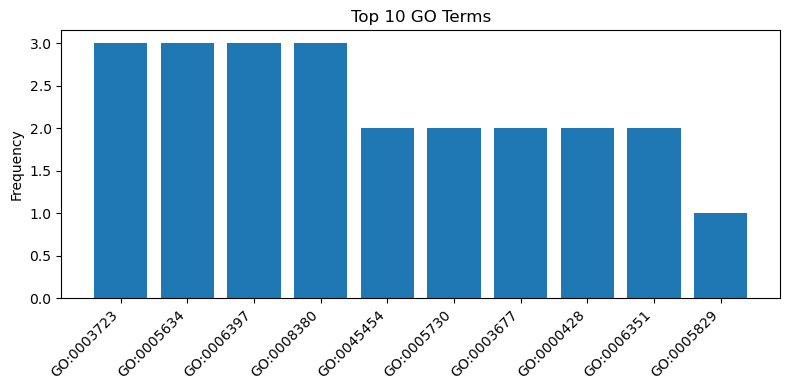

In [35]:
# Plot Top 10 GO terms 

top10 = go_counts.head(10).copy()

# In case the columns aren't named exactly 'GO_ID' and 'Count', rename them:
cols = list(top10.columns)
if cols[0] != 'GO_ID' or cols[1] != 'Count':
    top10.columns = ['GO_ID', 'Count']

# Plot
plt.figure(figsize=(8,4))
plt.bar(top10['GO_ID'], top10['Count'])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 GO Terms")
plt.ylabel("Frequency")
plt.tight_layout()

# Save to file
output_png = "/data/training2/analisis_TFM_Bulida_Precoz/10_functional_annotation/blast_annotation/top10_go_terms.png"
plt.savefig(output_png, dpi=300)

# Display
plt.show()



In [1]:
import os, subprocess
print(os.environ["PATH"].split(os.pathsep)[:5])
print(subprocess.run(["which","xelatex"], capture_output=True).stdout.decode())


['/data/training2/softwares/conda_envs/env_tfm_bulida/bin', '/data/training2/softwares/miniconda3/condabin', '/home/sie/rsat/ext_lib/ensemblgenomes-40-93/ensembl-git-tools/bin', '/home/sie/rsat/python-scripts', '/home/sie/rsat/perl-scripts/parsers']

